# Decision trees

There's a great set of videos on decision trees here from Victor Lavrenko: https://www.youtube.com/watch?v=eKD5gxPPeY0&list=PLBv09BD7ez_4temBw7vLA19p3tdQH6FYO. Very intuitive and easy to follow. This is what the notes below plus implementation are based on.  

The example we'll use is based on the videos above; this is saved into 'will_john_play_tennis.csv'. We're given 14 days on which John does, or does not, play tennis. For each of these days we are given the weather outlook, the humidity and whether it rained. One we have built the tree, via the algorithm, we can take a new set of inputs and predict whether John would play tennis on that day, based on the data we have seen.

The overall aproach can be summarised as a divide-and-conquer algorithm:
- split the data into subsets
- if they are pure, stop
- if they are not pure, repeat

There are a few steps we'll go through to look at different aspects of the problems as follows:
- What does it mean to split the data on an attribute?
- Generate tree given attributes to split on
- Given tree, make prediction
- Determining which attribute to split on
- Generate tree with attribution split based on information gain
- How to prevent overfitting
- Application to continuous variables
- Application to more than two classes
- Aggregating into an ensemble model as a random forest

Let's look at the data first though.....

In [31]:
import pandas as pd
df = pd.read_csv('will_john_play_tennis.csv', index_col=0)
df

,Outlook,Humidity,Wind,Play
Day,,,,
D1,Sunny,High,Weak,No
D2,Sunny,High,Strong,No
D3,Overcast,High,Weak,Yes
D4,Rain,High,Weak,Yes
D5,Rain,Normal,Weak,Yes
D6,Rain,Normal,Strong,No
D7,Overcast,Normal,Strong,Yes
D8,Sunny,High,Weak,No
D9,Sunny,Normal,Weak,Yes


# What does it mean to split the data on an attribute?

When we talk about decision trees, we talk about attributes and splitting. It's useful to visualise what this looks like, before we dive too deep into the details. Let's start with the complete dataset, and split on outlook. The code below demos this using the graphviz library, which is a very convenient way to visualise any kind of graph or tree. It also leverages the functionality in pandas, whereby a given dataframe can be exported in different ways; in this case we export the markdown table text that we can display for each node.

The steps are:
- start with complete dataset at the root
- get unique categories for attribute (outlook)
- create three child nodes that represent splitting the dataset on the 3 unique values

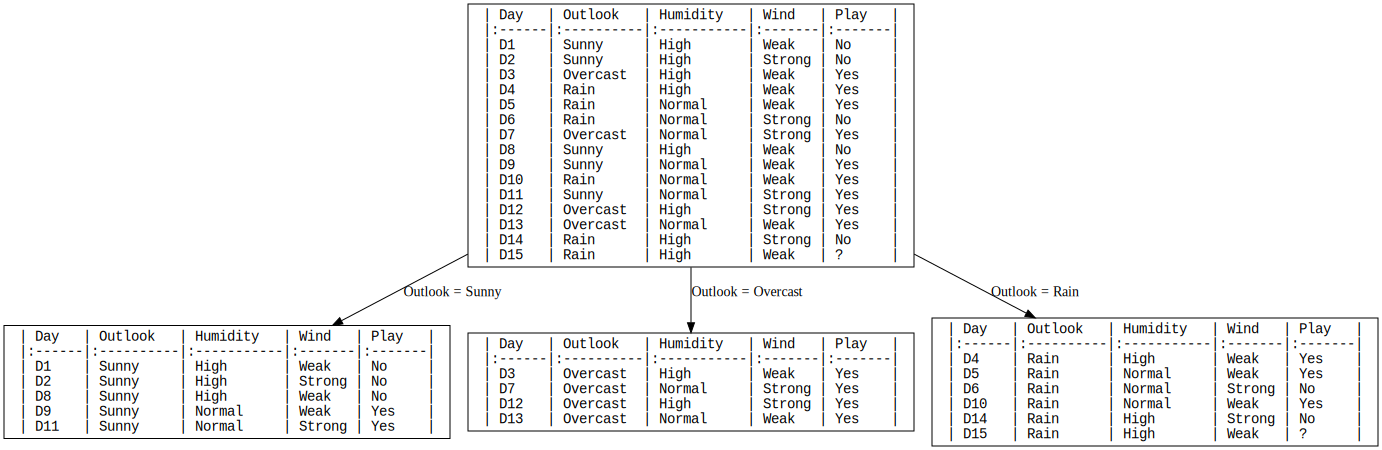

In [32]:
# start with split on outlook, which creates 3 subsets
# we can visualise these using graphviz
import graphviz

unique_cats = df.Outlook.unique()
gv = graphviz.Digraph()
gv.node('root',
        df.to_markdown(), 
        fontname = "courier",
        shape = 'box')
for i,uc in enumerate(unique_cats):
    idx = (df.Outlook == uc)
    df_subset = df.loc[idx]
    pure_subset = all(df_subset.Play == 'Yes')
    gv.node(f'node{i}',
            df_subset.to_markdown(), 
            fontname = "courier",
            shape = 'box')
    gv.edge('root', f'node{i}',
            f'Outlook = {uc}')

gv

# Generate a tree given attributes to split on

The code above gives us an idea of what's involved. For the next step, we'll consider how to construct a tree given a series of attributes to split on; this is a little trickier due to the recursive nature of the algorithm. We'll use a queue approach to keep track of the nodes. We start with the root node, and pop it off the front of the node list. We then add the nodes that correspond to the unique categories of the first attribute split, and the process repeats i.e. we would then pop off the first unique category result, and split on the second attribute, etc.

As a first step let's define a simple structure, via a namedtuple, that captures the state of the problem.
- _id_ is a unique node id
- _counts_ is a dictionary of values that scores the number of values we're interested in i.e. yes/no as to whether John plays 
- _df_ is the dataframe associated with the node e.g. the complete dataset at the root node
- _levels_ is a list of the attributes that we split the data on, reducing in length by one each time we split
- _split_on_ is a tuple of the attribute and value from which the current node was split on, or None for the root node 

In [33]:
from collections import namedtuple

DT_node = namedtuple('DT_node', 'id counts df levels split_on')

Define a small function to extract the values count, and also define the representation of the namedtuple struct as something similar to the above; we'd like to see, for a given node, the salient information. Defining this once means that we can more easily and succincty create the tree diagrams. Note the '\l' left justifies the text for graphviz.

In [34]:
def get_value_counts(col, unique_values):
    counts = {}
    for uv in unique_values:
        counts[uv] = sum(col == uv)
    return counts

assert get_value_counts(df.Play, ['Yes', 'No']) == {'Yes' : 9,
                                                   'No' : 5}
  
DT_node.__repr__ = lambda dtn: \
    f'ID:       {dtn.id}' + '\l' + \
    f'Counts:   {str(dtn.counts)}' + '\l' + \
    f'Levels:   {dtn.levels}' + '\l' + \
    f'Split on: {None if not dtn.split_on else (dtn.split_on)}' + '\l\l' + \
    dtn.df.to_markdown() 

Create the root node and view the contents.

In [35]:
root_tennis = DT_node(id = 0,
                      counts = get_value_counts(df.Play, ['Yes', 'No']),
                      df = df,
                      levels = ['Outlook', 'Humidity', 'Wind'],
                      split_on = None)
print(root_tennis)

ID:       0\lCounts:   {'Yes': 9, 'No': 5}\lLevels:   ['Outlook', 'Humidity', 'Wind']\lSplit on: None\l\l| Day   | Outlook   | Humidity   | Wind   | Play   |
|:------|:----------|:-----------|:-------|:-------|
| D1    | Sunny     | High       | Weak   | No     |
| D2    | Sunny     | High       | Strong | No     |
| D3    | Overcast  | High       | Weak   | Yes    |
| D4    | Rain      | High       | Weak   | Yes    |
| D5    | Rain      | Normal     | Weak   | Yes    |
| D6    | Rain      | Normal     | Strong | No     |
| D7    | Overcast  | Normal     | Strong | Yes    |
| D8    | Sunny     | High       | Weak   | No     |
| D9    | Sunny     | Normal     | Weak   | Yes    |
| D10   | Rain      | Normal     | Weak   | Yes    |
| D11   | Sunny     | Normal     | Strong | Yes    |
| D12   | Overcast  | High       | Strong | Yes    |
| D13   | Overcast  | Normal     | Weak   | Yes    |
| D14   | Rain      | High       | Strong | No     |
| D15   | Rain      | High       | Weak   | ?  

Write the function to return a dictionary of nodes, with the ID as key, and a dictionary mapping node IDs from parent to children. The inputs are the root node, plus the target column and values.

In [36]:
def gen_dec_tree_given_attrs_to_split_on(root, target_col, target_vals):
    node_count = root.id + 1
    nodes_to_visit = [root]
    nodes = {}
    node_mappings = {}

    while nodes_to_visit:
        node = nodes_to_visit.pop(0)
        nodes[node.id] = node
        if node.levels:
            level_to_split_on = node.levels[0]
            next_levels = node.levels[1:]
            unique_cats = node.df[level_to_split_on].unique()
            node_mappings[node.id] = [node_count+i for i,_ in enumerate(unique_cats)]
            for uc in unique_cats:
                idx = node.df[level_to_split_on] == uc
                df_subset = node.df.loc[idx]
                next_node = DT_node(id = node_count,
                                    counts = get_value_counts(df_subset[target_col], target_vals),
                                    df = df_subset,
                                    levels = next_levels,
                                    split_on = (level_to_split_on, uc))

                nodes_to_visit.append(next_node)
                node_count = node_count + 1

    return (nodes, node_mappings)

nodes_tennis, node_mappings_tennis = gen_dec_tree_given_attrs_to_split_on(
    root = root_tennis,
    target_col = 'Play',
    target_vals = ['Yes', 'No'])
    

Use graphviz to generate a tree from this output.

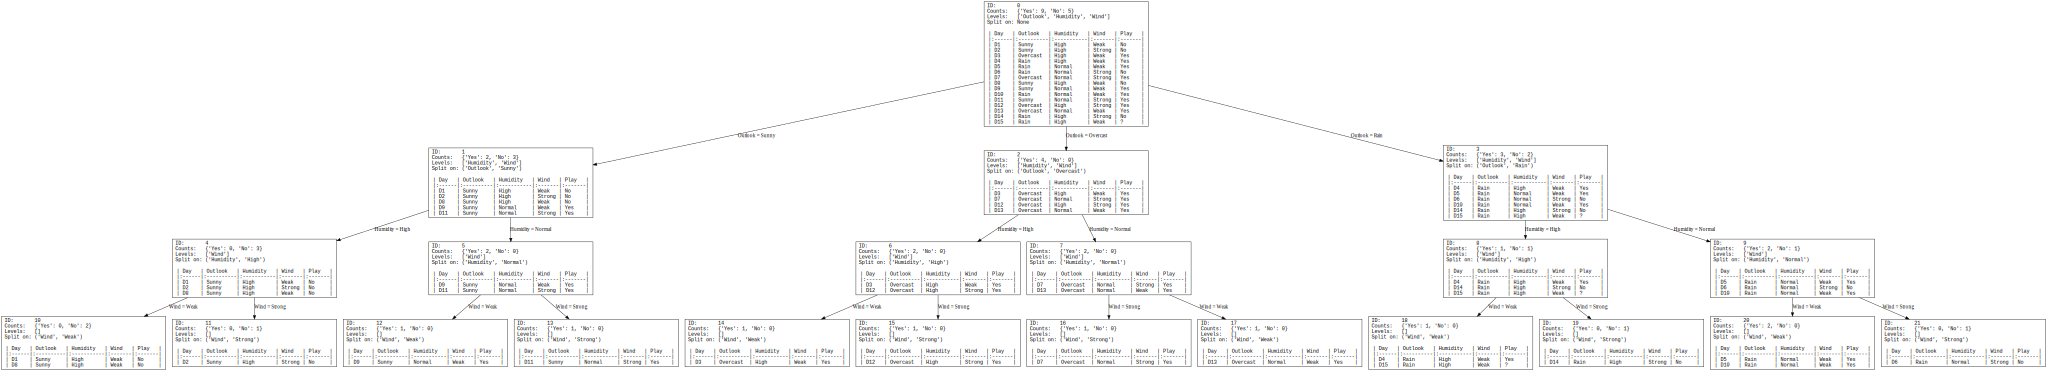

In [37]:
def gen_dec_tree_graphviz(nodes, node_mappings):
    gv = graphviz.Digraph()
    for node_id,node in nodes.items():
        gv.node(str(node_id), str(node),fontname='courier', shape='box')
    for node_id,next_node_ids in node_mappings.items():
        for nnid in next_node_ids:
            nn = nodes[nnid]
            edge_label = f'{nn.split_on[0]} = {nn.split_on[1]}'
            gv.edge(str(node_id), str(nnid), edge_label)
    return gv
    
gen_dec_tree_graphviz(nodes_tennis, node_mappings_tennis)

# Given a tree and data, make a prediction

We have the tree structure in terms of the nodes and the node mappings. Given a new piece of data, we can use the tree to predict a value. The original problem was to predict whether John would play on day 15, given a rainy outlook, high humidity and weak wind.

| Day   | Outlook   | Humidity   | Wind   | Play   |
|:------|:----------|:-----------|:-------|:-------|
| D15   | Rain      | High       | Weak   | ?      |

In the tree above we can trace this route down to a leaf node:
- from the root we look at the 3 child nodes that are split on outlook
- given that the outlook is rain, we can follow the _Outlook = Rain_ path
- from this node we look at the 2 child nodes that are split on humidity
- given that the humidity is high, we can folow the _Humidity = High_ path
- this takes us to a leaf node, which is pure in the sense that there is a single non-zero value in the node count dictionary
- ....so we return 'Yes'

In general we will not know in advance how the tree is structured in respect of the order in which attributes are split - more on this in the next section. We can use a dictionary to pass the state of the input we wish to predict, with the key-value pairs being the attribute and the attribute value, respectively. This can then be compared to the _split_on_ attribute of each child node in the tree to determine which path to follow.

We can optionally return a graphviz that shows the sequence of nodes traversed in the decision tree. This is optional since the prediction might in general be applied to large data sets.

In [38]:
def predict_dec_tree(nodes, node_mappings, input_data, output_gv=False):
    node = nodes[0] # default assumption that zero is the root node
    if output_gv: 
        gv = graphviz.Digraph()
        gv.node(str(node.id), str(node),fontname='courier', shape='box')
        parent_node_id = node.id
    
    while node.id in node_mappings:
        next_nodes = [nodes[nnid] for nnid in node_mappings[node.id]]
        attr_to_split_on = next_nodes[0].split_on[0] # identical for all, take from first entry
        value_in_data = input_data[attr_to_split_on]
        # find node that corresponds to this attribute-value pair
        # by construction there should only be one value
        idx = [i for i,nn in enumerate(next_nodes) if nn.split_on[1] == value_in_data][0]
        node = next_nodes[idx]
        if output_gv: 
            gv.node(str(node.id), str(node),fontname='courier', shape='box')
            gv.edge(str(parent_node_id), str(node.id))
            parent_node_id = node.id

    # max function applied on a dictionary returns max-by value, which is what we want
    return max(node.counts) if not output_gv else (max(node.counts), gv)
    
input_d15 = {'Outlook' : 'Rain',
             'Humidity' : 'High',
             'Wind' : 'Weak'} 
tom_plays_d15_prediciton, gv = predict_dec_tree(nodes_tennis, node_mappings_tennis, input_d15, output_gv=True)
print(f'Decision tree predicts that Tom plays: {tom_plays_d15_prediciton}')

Decision tree predicts that Tom plays: Yes


View the sequence through the tree.

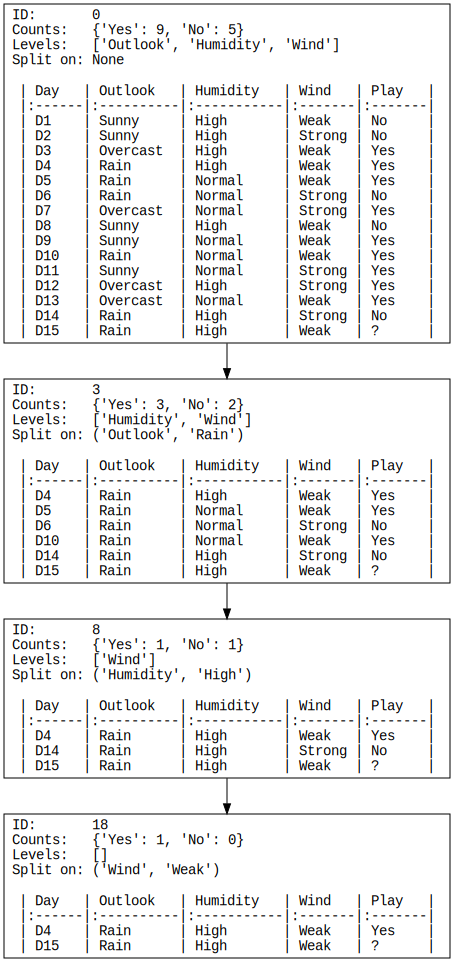

In [39]:
gv

# Determining which attribute to split on

Thus far we have specified the sequence of levels to split on. A key part of the decision tree approach is that we can, from an information perspective, select an optimal attribute to split on at any point in the tree. We start by specifying the entropy of a given state: https://en.wikipedia.org/wiki/Entropy_(information_theory)

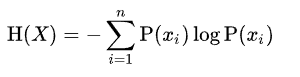

The input to this function is the _counts_ attribute of the node structure. This maps each unique category of an attribute to the number of instances in the data. For example, for the tennis data set, the counts attribute is:

In [40]:
root_tennis.counts

{'Yes': 9, 'No': 5}

We calculate the entropy directly from this.

In [41]:
import numpy as np

def calculate_entropy(counts):
    ni = np.array(list(counts.values()))
    sum_ni = np.sum(ni)
    pi = ni/sum_ni
    entropy = 0 if (any(pi == 0)) else -np.sum([pi * np.log2(pi)])
    return entropy

root_tennis_entropy = calculate_entropy(root_tennis.counts)
print(f'entropy on root node: {root_tennis_entropy}')

entropy on root node: 0.9402859586706311


Given this function we can calculate the entropy associated with a given node and its children, for a given attribute split. Remember that we can split a given node, in general, in a number of different ways that correspond to the remaining attributes in the data set. The application of entropy allows us to identify which attribute split gives us the most 'information gain'; since entropy represents uncertainty, we want the attribute split that maximises the reduction in entropy.

In the current example, from the root node we can split on outlook, humidity or wind. Let's compute the entropy associated with each one. The code below is a little messy, and will be tidied into a function soon. For the moment we're just using it to see what's going on. The _entropy_in_children_ dictionary will help us to visualise this.

In [42]:
target_col = 'Play'
target_vals = ['Yes', 'No']
node = root_tennis
df = node.df

import pdb

attributes = ['Outlook', 'Humidity', 'Wind']
entropy_on_attribute_split = {}
entropy_in_children = {}
for attr in attributes:
    entropy_in_children[attr] = {}
    unique_cats = df[attr].unique()
    df_subsets = [df.loc[df[attr] == uc] for uc in unique_cats]
    countss = [get_value_counts(dfs[target_col], target_vals) for dfs in df_subsets]
    entropy_subsets = np.array([calculate_entropy(counts) for counts in countss])
    entropy_in_children[attr] = dict(zip(unique_cats, entropy_subsets))
    weightings = np.array([sum(counts.values())/df.shape[0] for counts in countss])
    entropy_on_attribute_split[attr] = np.sum(weightings * entropy_subsets)

We can visualise this information to show that, on an information gain basis, the outlook attribute would be selected since it leads to the largest expected gain in information / reduction in entropy.

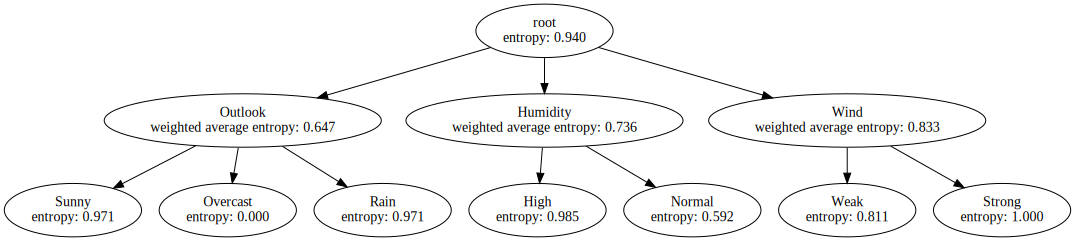

In [43]:
gv = graphviz.Digraph()
gv.node('root', f'root\nentropy: {root_tennis_entropy:.3f}')

for attr in attributes:
    gv.node(attr, f'{attr}\nweighted average entropy: {entropy_on_attribute_split[attr]:.3f}')
    gv.edge('root', attr)
    for uc, entropy in entropy_in_children[attr].items():
        gv.node(uc, f'{uc}\nentropy: {entropy:.3f}')
        gv.edge(attr, uc)

gv

# Generate a tree with attribution split based on information gain

We can convert the snippet above into a function, and use within a new gen_dec_tree.... based off entropy insead of a pre-determined sequence of attributes. It doesn't function that differently, except that the level to split on is now popped from the appropriate index that relates to the attribute with maximum information gain.

From a function perspective, we have:
- _get_optimal_attribute_split_: new function that returns optimal split from current node
- _gen_dec_tree_given_attrs_to_split_on_: existing function that generates (nodes, node mappings) pair based on pre-determined split 
- _gen_dec_tree_via_entropy_: new function that generates (nodes, node mappings) pair based on entropy splits 


In [44]:
def get_optimal_attribute_split(node, target_col, target_vals):
    df = node.df
    
    attributes = node.levels
    entropy_on_attribute_split = {}
    entropy_in_children = {}
    for attr in attributes:
        entropy_in_children[attr] = {}
        unique_cats = df[attr].unique()
        df_subsets = [df.loc[df[attr] == uc] for uc in unique_cats]
        countss = [get_value_counts(dfs[target_col], target_vals) for dfs in df_subsets]
        entropy_subsets = np.array([calculate_entropy(counts) for counts in countss])
        entropy_in_children[attr] = dict(zip(unique_cats, entropy_subsets))
        weightings = np.array([sum(counts.values())/df.shape[0] for counts in countss])
        entropy_on_attribute_split[attr] = np.sum(weightings * entropy_subsets)
    #pdb.set_trace()
    return min(entropy_on_attribute_split, key=entropy_on_attribute_split.get)

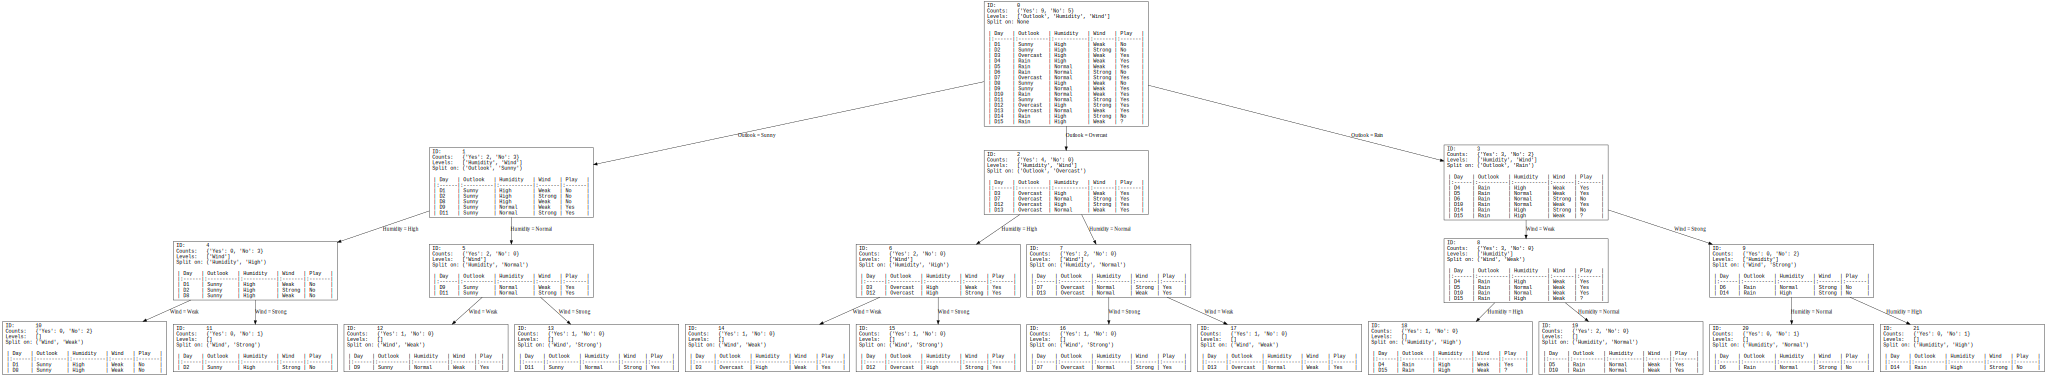

In [45]:
def gen_dec_tree_via_entropy(root, target_col, target_vals):
    node_count = root.id + 1
    nodes_to_visit = [root]
    nodes = {}
    node_mappings = {}

    while nodes_to_visit:
        node = nodes_to_visit.pop(0)
        nodes[node.id] = node
        if node.levels:
            
            level_to_split_on = get_optimal_attribute_split(node, target_col, target_vals)
            next_levels = node.levels.copy()
            next_levels.remove(level_to_split_on)
            unique_cats = node.df[level_to_split_on].unique()
            node_mappings[node.id] = [node_count+i for i,_ in enumerate(unique_cats)]
            for uc in unique_cats:
                idx = node.df[level_to_split_on] == uc
                df_subset = node.df.loc[idx]
                next_node = DT_node(id = node_count,
                                    counts = get_value_counts(df_subset[target_col], target_vals),
                                    df = df_subset,
                                    levels = next_levels,
                                    split_on = (level_to_split_on, uc))

                nodes_to_visit.append(next_node)
                node_count = node_count + 1

    return (nodes, node_mappings)

nodes_tennis_via_entropy, node_mappings_tennis_via_entropy = gen_dec_tree_via_entropy(
    root = root_tennis,
    target_col = 'Play',
    target_vals = ['Yes', 'No'])
    
gen_dec_tree_graphviz(nodes_tennis_via_entropy, node_mappings_tennis_via_entropy)

# Preventing bias towards attributes with many values - TODO



# How to prevent overfitting - TODO

- in current approach keep splitting data till there are pure subsets
- notion of pruning to prevent this
- look at perforamce of training vs. test data sets
- 2 x options
    - when you split - do significant test i.e. what are the chances that this happened randomly
    - grow to full depth then prune branches


# Application to continuous variables - TODO

- continuous
- introduce threshold
- that threshold can be optimised

# Application to more than two classes - TODO

- multiclass
- different definition of entropy

# Aggregating into an ensemble model as a random forest - TODO